# **Finding the Closest OSM Objects to me**
##### **A missing semester project by Tyler Kelsey**

In this project, we're going to get OSM objects and sort them by distance. OSM stands for OpenStreetMap, and is an open-source project with the goal of being a "free, editable map of the whole world made by people like you". In this notebook, we're specifically going to get the closest psychotherapists to me, in Freiburg, and see what interesting data we can plot.

If you are just interested in the command-line tool, refer to the main.py file.

Currently, due to data and scope limitations, this tool only allows locations in Germany.

**Overview**
- **General code**
 - **Plot for all doctors**
 - **Plot healthcare percentages**
 - **Plot for psychotherapists**
 - **Web scraping phone numbers**
 - **Plot their distance**

#### **User Input:**

In [1]:

input_address = "Lehener Str 90 Freiburg"
input_tag = "healthcare=psychotherapist" # this needs to be a valid OSM tag
radius = 3 # in km


#### **Find user's address**

In [2]:
import pyrosm
from pyrosm.data import sources
from geopy.geocoders import Nominatim
import re

# Nominatim allows easy free-form text to address transformation

geolocator = Nominatim(user_agent='tag_finder')
user_location = geolocator.geocode(input_address, addressdetails=True)
if user_location is None:
    raise Exception("Inputted address could not be found")


standardize_letters = lambda x: x.replace("ü", "ue").replace("ä", "ae").replace("ö", "oe").replace("ß", "ss")
user_address = {
                    'housenumber':                          user_location.raw['address']['house_number'],
                    'street':           standardize_letters(user_location.raw['address']['road']),
                    'state':            standardize_letters(user_location.raw['address']['state']),
}

# Nominatim will not always have a 'city' in an address.
try:
    user_address['city'] = standardize_letters(user_location.raw['address']['city'])
except:
    try:
        user_address['city'] = standardize_letters(user_location.raw['address']['village'])
    except:
        user_address['city'] = ""

print(user_address, user_location.longitude, user_location.latitude)

{'housenumber': '90', 'street': 'Lehener Strasse', 'state': 'Baden-Wuerttemberg', 'city': 'Freiburg im Breisgau'} 7.8306164 48.0039849


#### **Initialize the dataframe**

In [3]:
import math

# We can't use the entirety of germany as that would take too much ram.
# First we try and see if there if data for our city - If we live in the countryside we need to use the entire state.

print('Starting download of PBF data...')
try:
    fp = pyrosm.get_data(user_address["city"])
except: 
    try:
        print(f"Could not find data for '{user_address['city']}', using '{user_address['city'][:user_address['city'].find(' ')]}' instead.")
        fp = pyrosm.get_data(user_address["city"][:user_address["city"].find(' ')]) # Turn cities like 'Freiburg im Breisgau' into 'Freiburg'.
    except:
        print(f"Could not find PBF data for '{user_address['city']}'. Loading entire area '{user_address['state']}' instead...")

        try:
            fp = pyrosm.get_data(user_address["state"])
        except:
            try:
                fp = pyrosm.get_data(user_address["state"][:user_address["state"].find(' ')])
            except:
                print(f"Couldn't find PBF data for {user_address['state']}. Aborting.")
print('Completed download of PBF data.')

# The data is stored in /temp/pyrosm so you don't have to worry about deleting it.

Starting download of PBF data...
Could not find data for 'Freiburg im Breisgau', using 'Freiburg' instead.
Completed download of PBF data.


#### **Fill our dataframe with OSM data, and work with longitude and latitude**

In [4]:
# Latitude: 1 deg = 110.574 km
# Longitude: 1 deg = 111.320*cos(latitude) km

latitude_radius = float(radius) / 110.574
longitude_radius = float(radius) / (111.320 * math.cos(math.radians(user_location.latitude)))
bounding_box = [user_location.longitude - longitude_radius, user_location.latitude - latitude_radius, user_location.longitude + longitude_radius, user_location.latitude + latitude_radius]


def get_distance(curr_lon: float, curr_lat: float, target_lon: float, target_lat: float) -> float:
    # Haversine formula: https://stackoverflow.com/questions/4913349/haversine-formula-in-python-bearing-and-distance-between-two-gps-points
    
    curr_lat, curr_lon, target_lat, target_lon = map(math.radians, [curr_lat, curr_lon, target_lat, target_lon])

    d_lat = target_lat - curr_lat
    d_lon = target_lon - curr_lon
    a = math.sin(d_lat / 2)**2 + math.cos(curr_lat) * math.cos(target_lat) * math.sin(d_lon / 2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    
    return 6371.0 * c

height = str(abs(bounding_box[1] - bounding_box[3]) * 110.574)[:4] 

print(f"Grid size is: {height} x {height} km.")
print(f"Area is: ~{str(float(height)*float(height))[:5]} km².")

osm = pyrosm.OSM(fp, bounding_box=bounding_box)


Grid size is: 5.99 x 5.99 km.
Area is: ~35.88 km².


#### **Plot: All healthcare in radius of the user**

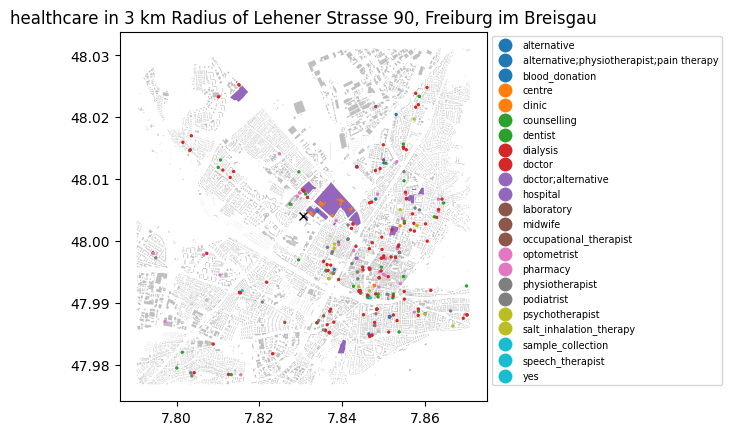

In [5]:
import matplotlib.pyplot as plt

# Extract the input tag
if "=" in input_tag:
    (OSM_key, OSM_value) = input_tag.split("=")
else:
    (OSM_key, OSM_value) = input_tag, None

custom_filter = {OSM_key : True}

# Foreground: Healthcare points of interest (POIs)
pois = osm.get_pois(custom_filter=custom_filter, extra_attributes=[OSM_key])
pois["poi_type"] = pois[OSM_key]

# Background: Buildings
buildings = osm.get_buildings(extra_attributes=["building"])

ax = buildings.plot(color='0.75')
ax = pois.plot(column="poi_type", ax=ax, legend=True, markersize=2, figsize=(20,20), legend_kwds=dict(loc='upper left', fontsize='x-small', ncol=1, bbox_to_anchor=(1, 1)))
ax.plot(user_location.longitude, user_location.latitude, 'x', markersize=6, color='0.0') 
plt.title(f"{OSM_key} in {radius} km Radius of {user_address["street"]} {user_address["housenumber"]}, {user_address["city"]}")
plt.savefig('images/freiburg_healthcare.pdf')

#### **Plot: Percentage of each type of available healthcare**

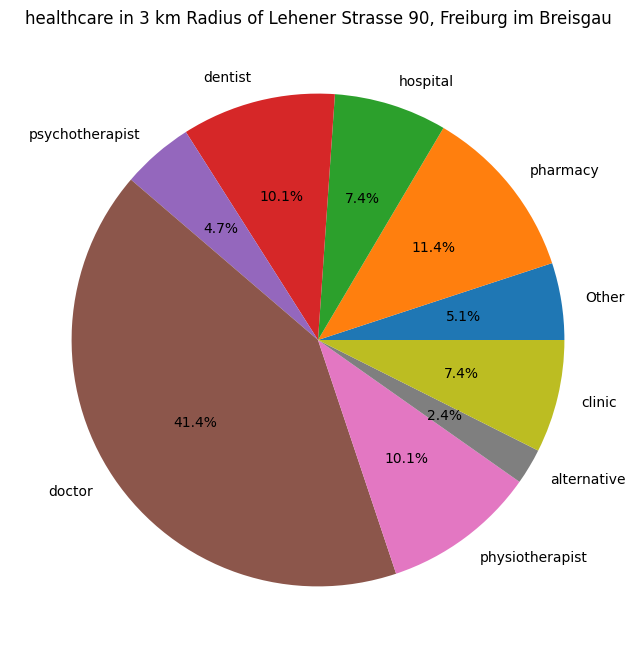

In [6]:
counted_targets = {}

# Count the amount of each type of doctor
for index, row in pois.iterrows():
    if row["poi_type"] in counted_targets.keys():
        counted_targets[row["poi_type"]] += 1
    else:
        counted_targets[row["poi_type"]] = 1

counted_targets_grouped = {}
counted_targets_grouped["Other"] = 0

# Group together all uncommon ones
for k, v in counted_targets.items():
    if v <= pois.shape[0] / 50: # Has to reach 2% of total to not be grouped as 'other'
        counted_targets_grouped["Other"] += 1
    else:
        counted_targets_grouped[k] = v

sizes = counted_targets_grouped.values()
labels = counted_targets_grouped.keys()

fig, ax = plt.subplots(figsize=(8,8))
ax.pie(sizes, labels=labels, autopct='%1.1f%%')
plt.title(f"{OSM_key} in {radius} km Radius of {user_address["street"]} {user_address["housenumber"]}, {user_address['city']}")
plt.savefig('images/freiburg_healthcare_pie.pdf')

#### **Plot: Psychotherapists in radius of user, and fixing missing coordinates**

    version          id visible  changeset  \
15        0   571123133   False        0.0   
16        0   571123134   False        0.0   
17        0   571123142   False        0.0   
18        0   575881776   False        0.0   
70        0  2643363583   False        0.0   

                                                 tags  timestamp        lat  \
15                   {"note:de":"Diplom-Psychologin"}          0  47.993942   
16  {"note:de":"Diplom-Psychologin, psychologische...          0  47.993965   
17  {"note:de":"Diplom-Psychologin, psychologische...          0  47.993950   
18  {"contact:phone":"+49 761 6126979","healthcare...          0  47.994854   
70  {"description":"Psych.-Psychotherapeutin, Verh...          0  47.992634   

         lon             addr:city addr:country  ...  \
15  7.836738  Freiburg im Breisgau         None  ...   
16  7.836719  Freiburg im Breisgau         None  ...   
17  7.836792  Freiburg im Breisgau         None  ...   
18  7.837304            

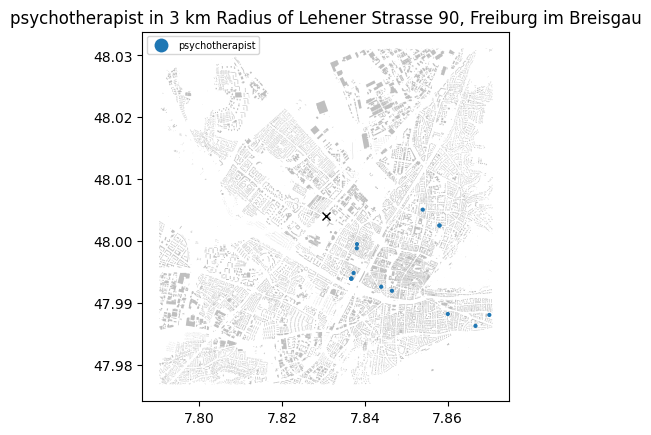

In [7]:
from shapely import Point

target_pois = pois.copy()[pois["poi_type"] == OSM_value]
print(target_pois.head())

# In rare cases, if all objects are missing coordinates, we need to add the columns to the dataframe.
if 'lat' not in target_pois.columns:
    target_pois.insert(0, 'lat', math.nan)
if 'lon' not in target_pois.columns:
    target_pois.insert(0, 'lon', math.nan)
     

# When objects are missing coordinates, manually add them.
for index, row in target_pois.iterrows():
        if math.isnan(row['lat']) or math.isnan(row['lon']):
            if row['geometry'] is not None:
                try: # geometry: shapely.polygon.Polygon
                    bbox = row['geometry'].exterior.bounds
                except: # geometry: shapely.MultiLineString
                    bbox = row['geometry'].bounds
                target_pois.at[index, 'lon'] = bbox[0]
                target_pois.at[index, 'lat'] = bbox[1]
                target_pois.at[index, 'geometry'] = Point(bbox[0], bbox[1])


ax = buildings.plot(color='0.75')
ax = target_pois.plot(column="poi_type", ax=ax, legend=True, markersize=4, figsize=(20,20), legend_kwds=dict(loc='upper left', fontsize='x-small', ncol=1))
ax.plot(user_location.longitude, user_location.latitude, 'x', markersize=6, color='0.0') 
plt.title(f"{OSM_value if OSM_value is not None else OSM_key} in {radius} km Radius of {user_address["street"]} {user_address["housenumber"]}, {user_address["city"]}")
plt.savefig('images/freiburg_psychotherapists.pdf')
    

#### **Format found psychotherapists, and output it in the console**

In [8]:
# Extracts specifically distances, names, and phones from the dataframe
targets = {}

# Extract data into dict, sanitize, then sort it
for index, row in target_pois.iterrows():
    name = row['name']
    phone = row['phone']

    if name is None:
        name = "Name not specified"
    if phone is None:
        phone = "Phone not specified"

    targets.update({(name, phone) : get_distance(user_location.longitude, user_location.latitude, row['lon'], row['lat'])})

targets = {k: v for k, v in sorted(targets.items(), key=lambda item: item[1])}

phones = [x[0][1] for x in targets.items()]
names = [x[0][0] for x in targets.items()]
distances = [x[1] for x in targets.items()]

for i in range(len(distances)):
    if i >= len(distances):
        break
    if distances[i] > float(radius):
        phones.pop(i)
        names.pop(i)
        distances.pop(i)

if len(distances) == 0:
    print("No target found in radius. Either the OSM tag is not valid, or no objects are in the radius.")

# Format the output
print("distance", "    Name".ljust(44), "Phone\n")
for i in range(len(distances)):
    print(str(distances[i])[:4] + " km", "    ", (names[i]).ljust(40), phones[i])

distance     Name                                     Phone

0.74 km      Andreas Hansen                           +4976115519658
0.79 km      Praxis für Systemische Therapie          Phone not specified
1.13 km      Kathinka Bettmann                        Phone not specified
1.20 km      Nicole Eiermann                          +49 761 8817961
1.20 km      Eva Wörner                               Phone not specified
1.20 km      Alexandra Hipfner-Sonntag                +49 761 2020206
1.60 km      Dipl.-Psych. Karen Ostern                +49 761 1551 9047
1.74 km      Name not specified                       Phone not specified
1.78 km      Dipl.-Psych. Sibylle Moos                Phone not specified
2.04 km      Psychotherapie Ronja Luft                +491789062201
2.04 km      Psychotherapie Becker und Heyner         +4976176674796
2.80 km      psychologie-wende                        Phone not specified
3.42 km      Dr. med. Andreas Lamprecht               +4976188867588


#### **Problem**
Here's a problem: Oftentimes, no phone number is supplied to OSM. We can fix this using web scraping.

## **Using Webscraping to get the Phone Numbers of Psychiatrists**

#### **Initialize our little helper chatbot**

In [9]:
from ollama import chat, ChatResponse

def oracle(_content, _model):
    response: ChatResponse = chat(model='qwen2.5:' + _model, messages=[
        {
            'role': 'user',
            'content': _content
        },
    ])
    return(response.message.content)

#### **Use a google search to find the doctor's webpages**

In [10]:
from googlesearch import search
import tqdm

no_scrape = False

translated_OSM_value = oracle(OSM_value, 'translate')

search_terms = [name + " " + translated_OSM_value + " " + user_address["city"] for name in names]

# Use an automated google search to get urls of the targets' websites
target_urls = []
for search_term in tqdm.tqdm(search_terms):
    if no_scrape:
        break
    #logging.info(search_term)
    if search_term == "":
        target_urls.append("")
        continue
    urls = search(search_term, num_results=2, lang="de")
    url = next(urls)
    if 'search?' in url:
        url = ""
    target_urls.append(url)
    print(search_term, url)

print(len(search_terms))

  8%|▊         | 1/13 [00:00<00:09,  1.29it/s]

Andreas Hansen Psychotherapeut Freiburg im Breisgau https://www.psychotherapie-hansen.de/


 15%|█▌        | 2/13 [00:01<00:08,  1.35it/s]

Praxis für Systemische Therapie Psychotherapeut Freiburg im Breisgau https://www.therapie.de/psychotherapie/-verfahren-/systemische-therapie/-ort-/freiburg-im-breisgau/


 23%|██▎       | 3/13 [00:02<00:06,  1.57it/s]

Kathinka Bettmann Psychotherapeut Freiburg im Breisgau 


 31%|███       | 4/13 [00:02<00:04,  1.80it/s]

Nicole Eiermann Psychotherapeut Freiburg im Breisgau https://supervision-freiburg.de/trainer/eiermann/


 38%|███▊      | 5/13 [00:02<00:04,  1.90it/s]

Eva Wörner Psychotherapeut Freiburg im Breisgau https://psychotherapie-woerner.de/


 46%|████▌     | 6/13 [00:03<00:03,  1.90it/s]

Alexandra Hipfner-Sonntag Psychotherapeut Freiburg im Breisgau https://www.arzt-auskunft.de/arzt/psychologische-psychotherapeutin-kinder-und-jugendlichenpsychotherapeutin/freiburg-im-breisgau/null-alexandra-hipfner-sonntag-2710799


 54%|█████▍    | 7/13 [00:03<00:03,  1.92it/s]

Dipl.-Psych. Karen Ostern Psychotherapeut Freiburg im Breisgau https://www.psychologenportal.de/karte/kostern.html


 62%|██████▏   | 8/13 [00:04<00:02,  2.05it/s]

Name not specified Psychotherapeut Freiburg im Breisgau 


 69%|██████▉   | 9/13 [00:04<00:01,  2.17it/s]

Dipl.-Psych. Sibylle Moos Psychotherapeut Freiburg im Breisgau https://sibylle-moos.de/


 77%|███████▋  | 10/13 [00:05<00:01,  2.24it/s]

Psychotherapie Ronja Luft Psychotherapeut Freiburg im Breisgau https://www.therapie.de/profil/ronja.luft/


 85%|████████▍ | 11/13 [00:05<00:00,  2.30it/s]

Psychotherapie Becker und Heyner Psychotherapeut Freiburg im Breisgau https://www.arztsuche-bw.de/index.php?suchen=1&id_z_arzt_praxis=78315


 92%|█████████▏| 12/13 [00:05<00:00,  2.34it/s]

psychologie-wende Psychotherapeut Freiburg im Breisgau https://psychologie-wende.de/


100%|██████████| 13/13 [00:06<00:00,  1.94it/s]

Dr. med. Andreas Lamprecht Psychotherapeut Freiburg im Breisgau https://pt-lamprecht.de/
13


#### **Scrape the found websites for phone numbers**

In [11]:
import requests

def fetch_html(_url):
    if _url == "":
        return ""
    return requests.get(_url).text
    
def sanitize_phone(_unsanitized_phone):
    return re.sub(r'\D', '', _unsanitized_phone)


# Get the phone numbers from the scraped website data
target_scraped_phones = []

for url in target_urls:
    if url == "":
        target_scraped_phones.append("Phone not specified")
        continue
    html = fetch_html(url)
    try:
        # This was a real pain... Regex for (most) german phone numbers.
        unsanitized_phone = re.search(r'(((\+49)( (\(0\)) )?|0\d{3,4}[\/ ])[^#%:;{},.\d\n]{0,3}(\d{3,10})[^#%:;{},.\d\n\w]?(\d{3,7})[^#%:;{},.\d\n\w]?(\d{2,4})?[^#%:;{},.\d\n\w]?(\d{0,2})?)', html).group(0)
    except:
        unsanitized_phone = ""
    phone = sanitize_phone(unsanitized_phone)
    target_scraped_phones.append(phone)
    

print("OSM Phone".ljust(35), "Scraped Phone".ljust(35), "Name")
for i in range(len(target_scraped_phones)):
    print(phones[i].ljust(30), target_scraped_phones[i].ljust(30), names[i])

combined_phones = phones.copy()

if not no_scrape:
    for i, x in enumerate(phones):
        if target_scraped_phones[i] == "":
            pass
        elif sanitize_phone(x) == target_scraped_phones[i]:
            pass
        else:
            combined_phones[i] = target_scraped_phones[i]

OSM Phone                           Scraped Phone                       Name
+4976115519658                                                Andreas Hansen
Phone not specified            01601491448                    Praxis für Systemische Therapie
Phone not specified            Phone not specified            Kathinka Bettmann
+49 761 8817961                                               Nicole Eiermann
Phone not specified                                           Eva Wörner
+49 761 2020206                49761202020607                 Alexandra Hipfner-Sonntag
+49 761 1551 9047                                             Dipl.-Psych. Karen Ostern
Phone not specified            Phone not specified            Name not specified
Phone not specified                                           Dipl.-Psych. Sibylle Moos
+491789062201                  01789062201                    Psychotherapie Ronja Luft
+4976176674796                 076176674796                   Psychotherapie Becker und 

#### **Outputting the formatted data, with combined phone numbers**

In [12]:
# Format the output

for i, phone in enumerate(combined_phones):
    if phone[:2] == '49':
        combined_phones[i] = '+49 ' + phone[2:]
    if phone[:1] == '0':
        combined_phones[i] = '0 ' + phone[1:]

truncate = 100 < len(distances)
print("distance", "    Name".ljust(44), "Phone\n")
for i in range(len(distances)):
    print(str(distances[i])[:4] + " km", "    ", (str(names[i])).ljust(40), str(combined_phones[i]))
    if (truncate and i >= 100):
        break


distance     Name                                     Phone

0.74 km      Andreas Hansen                           +4976115519658
0.79 km      Praxis für Systemische Therapie          0 1601491448
1.13 km      Kathinka Bettmann                        Phone not specified
1.20 km      Nicole Eiermann                          +49 761 8817961
1.20 km      Eva Wörner                               Phone not specified
1.20 km      Alexandra Hipfner-Sonntag                +49 761202020607
1.60 km      Dipl.-Psych. Karen Ostern                +49 761 1551 9047
1.74 km      Name not specified                       Phone not specified
1.78 km      Dipl.-Psych. Sibylle Moos                Phone not specified
2.04 km      Psychotherapie Ronja Luft                0 1789062201
2.04 km      Psychotherapie Becker und Heyner         0 76176674796
2.80 km      psychologie-wende                        0 15771201252
3.42 km      Dr. med. Andreas Lamprecht               0 76188867588


#### **Plot: Psychotherapists by distance to user**

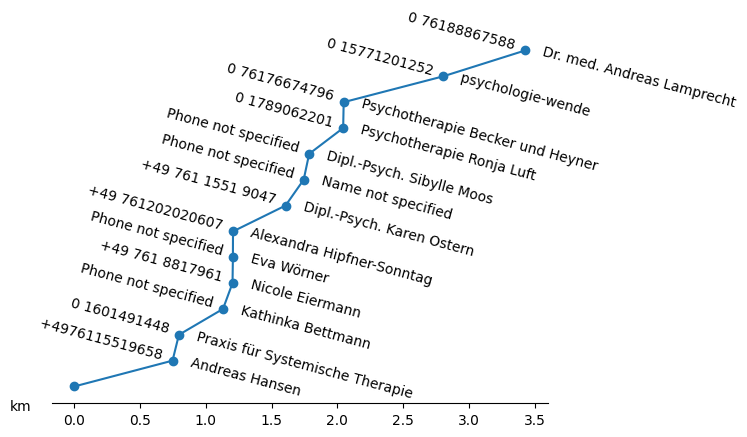

In [13]:
distances0 = [0] + distances
names0 = [""] + names
combined_phones0 = [""] + combined_phones


fig, ax = plt.subplots()
ax.plot(distances0, range(0,len(names0)), 'o-')
for i, txt in enumerate(names0):
    ax.annotate("    " + txt, (distances0[i], range(0,len(names0))[i]), rotation=-15, rotation_mode='anchor')

for i, txt in enumerate(combined_phones0):
    ax.annotate(txt + "  ", (distances0[i], range(0,len(names0))[i]), rotation=-15, horizontalalignment='right')

ax.annotate("km", (-30, -5), xycoords=('axes points'))
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_yticklabels([])
ax.set_yticks([])
plt.savefig('images/freiburg_psychotherapists_distance.pdf')
